ref: https://www.youtube.com/watch?v=VMj-3S1tku0&t=4151s

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
class Value:
  def __init__(self, data, _children=(), _op='', label='') -> None:
    self.data = data
    self.grad = 0.0     # 初始化 梯度为0.0
    self._backward = lambda: None   # a function that doesn't do anything but will be a back-prop function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    """
      data wrapper
      用来覆写 print() 方法的输出结果
    """
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    """
      用来覆写 + 的输出结果
    """
    other = other if isinstance(other, Value) else Value(other)   # 处理被加对象不是 Value的情况
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad   # 这里使用 += 是为了应对 b = a + a的情况，详见 1:25:40
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    """
      用来覆写 * 的输出结果
    """
    other = other if isinstance(other, Value) else Value(other)   # 处理被乘对象不是 Value的情况
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now... :("
    out = Value(self.data ** other, (self, ), f'** {other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad   # 幂函数求导
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    """
      用来覆写乘数不是Value 2 * Value(1.0) 的情况
    """
    return self * other
  
  def __truediv__(self, other):   # self / other
    return self * other ** -1
  
  def __neg__(self):      # define * -1 operation:
    return self * -1
  
  def __sub__(self, other):   # define substraction - operation
    return self + (-other)
    
  def __radd__(self, other):    # define int + Value 的情况
    return self + other
  
  def backward(self):
    topo = []; visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      # o = tanh(n)的导数为： 1 - tanh^2(n)
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(max(0, self.data), (self, ), 'relu')
    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out
  
  

In [27]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      #  add connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [28]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L.backward()

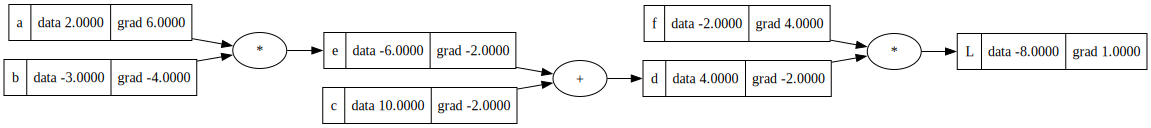

In [29]:
L.grad = 1.0    # L节点对于L节点自己的梯度 就是1.

"""
  下图中的所有节点的 grad 计算的都是当前节点对于 L节点的梯度。
  例如：节点e的grad 就是 de / dL
"""
draw_dot(L)

In [30]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')

  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')

  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-3.9999999999995595


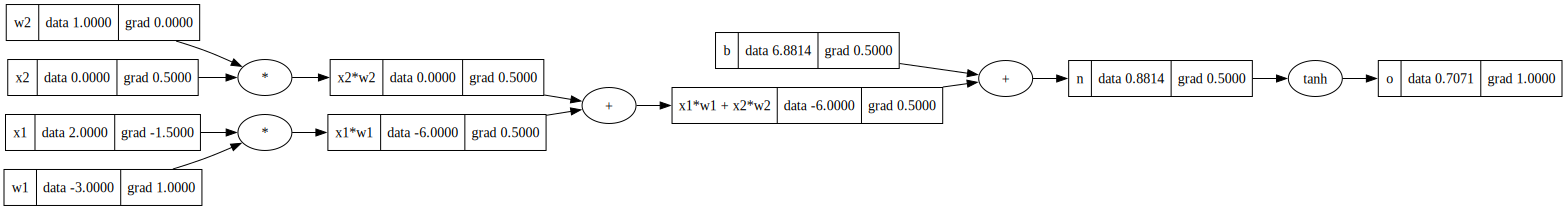

In [31]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'
o.backward()

draw_dot(o)

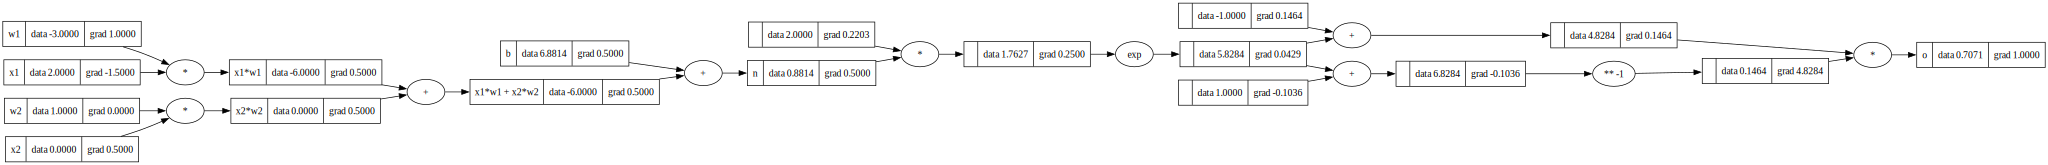

In [32]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'; o.backward()
draw_dot(o)

In [33]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('<=============================>')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

torch.Tensor([[1, 2, 3], [4, 5, 6]])

0.7071066904050358
<=============================>
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [34]:
import random

class Neuron:
  def __init__(self, nin: int):
    """
      每个Neuron类在初始化的时候会默认创建一个长度为 nin 的 权重向量和 一个bias（单一）值。
      权重的值和bias的值都服从均匀分布，值域在[-1, 1] 之间 (inclusive)
    """
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    """
    覆写 n(x) 方法调用。案例：x = [2.0, 3.0]; n = Neuron(x)；__call__覆写的是 n(x)
    该方法就是用来将当前neuron的权重 self.w 与 某个传入节点的 x 值 进行element-wise相乘相加，然后加上自身的 bias self.b
    然后通过一个激活函数激活 并输出。
    算例：
      self.w = [1,2,3]; x = [2,3,5], self.b = -10; 激活函数为tanh
      (1 * 2) + (2 * 3) + (3 * 5) - 10 = 13
    :return => tanh(13)
    """
    # zip 方法是将传入的参数组对。例如 w=[1,2,3]; x=[2,3,5]. list(zip(w, x)) = [(1, 2), (2, 3), (3, 5)]
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  

class Layer:
  def __init__(self, nin: int, nout: int):
    """
    @param: nout is the number of output Neurons of this Layer
    @param: nin is the number of input Neurons of this Layer
    """
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    """
      覆写的是 Layer(x) 这个函数调用
    """
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, nin: int, nouts):
    """
      @param: nouts 是MLP的每个layer所对应的 output Neurons的个数
    """
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# draw_dot(n(x))

In [35]:
x = [2.0, 3.0, -1.0]    # input data
n = MLP(3, [4, 4, 1])   # 第一个hidden layer有 4 个neurons；第二个hidden layer有 4 个neurons；最后的输出层只有一个neuron。所以是binary-classification
n(x)


Value(data=0.6183611868736849)

In [36]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]                             # input data
ys = [1.0, -1.0, -1.0, 1.0]   # desired targets

learning_rate = 0.1
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
      p.grad = 0.0          # 确保每次backward之前都将每一个 参数的 梯度值 归零
  loss.backward()

  # update parameters
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  print(f'Loss at step {k}: {loss.data}', ypred)

ypred

Loss at step 0: 4.118608525991705 [Value(data=0.6183611868736849), Value(data=0.8257023984625466), Value(data=-0.22817269903180284), Value(data=0.7901102383738173)]
Loss at step 1: 2.284103414492302 [Value(data=0.11300982031192978), Value(data=0.13841910709842128), Value(data=-0.8371247214557924), Value(data=0.5818787067589039)]
Loss at step 2: 0.9174757603869288 [Value(data=0.9189074529578856), Value(data=-0.06650077277344986), Value(data=-0.8353209729492378), Value(data=0.8888254974456848)]
Loss at step 3: 0.11338251665923052 [Value(data=0.8147727326322889), Value(data=-0.8084369040911998), Value(data=-0.9436698024790204), Value(data=0.8020003403644232)]
Loss at step 4: 0.07958721110324372 [Value(data=0.8591352449176369), Value(data=-0.8176901501018615), Value(data=-0.9469556996576087), Value(data=0.8460722484081119)]
Loss at step 5: 0.06425342665159663 [Value(data=0.8767674336034379), Value(data=-0.8314826426337047), Value(data=-0.950477677111858), Value(data=0.8650311108701102)]
Lo

[Value(data=0.9370279109147251),
 Value(data=-0.9123598118695626),
 Value(data=-0.9706079306772339),
 Value(data=0.9320132589396849)]